In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import random
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path

import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.autograd import Variable

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb

In [3]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

CUDA is available!  Training on GPU ...


In [4]:
info=pd.read_csv("/content/drive/MyDrive/Datasets/MIAS/all-mias-clahe/Info.txt",sep=" ")
info=info.drop('Unnamed: 7',axis=1)
info.SEVERITY.fillna(0)

0      B
1      B
2      0
3      0
4      B
      ..
325    0
326    0
327    0
328    0
329    0
Name: SEVERITY, Length: 330, dtype: object

<Axes: ylabel='CLASS'>

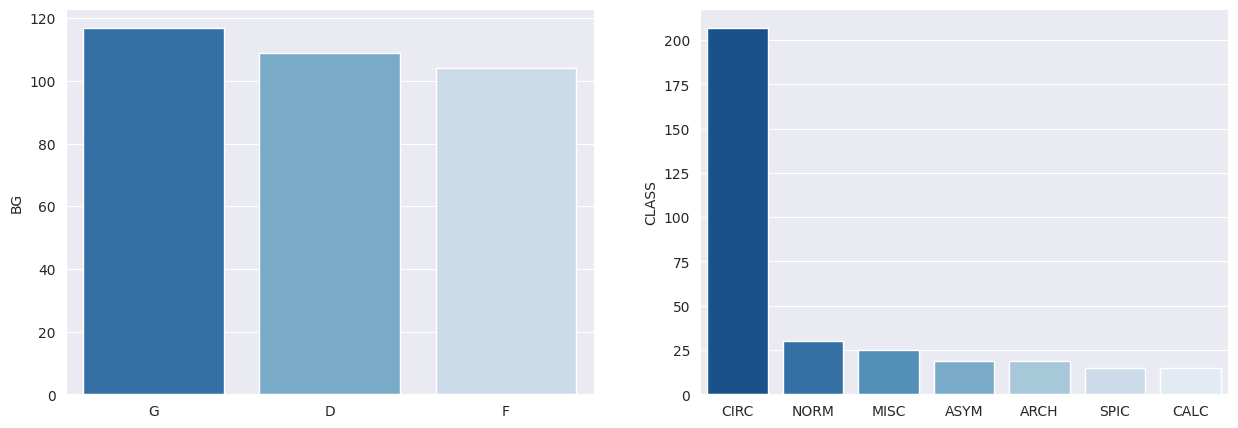

In [5]:
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x=info.BG.unique(),y=info.BG.value_counts(),palette='Blues_r',ax=ax1)
sns.barplot(x=info.CLASS.unique(),y=info.CLASS.value_counts(),palette='Blues_r',ax=ax2)

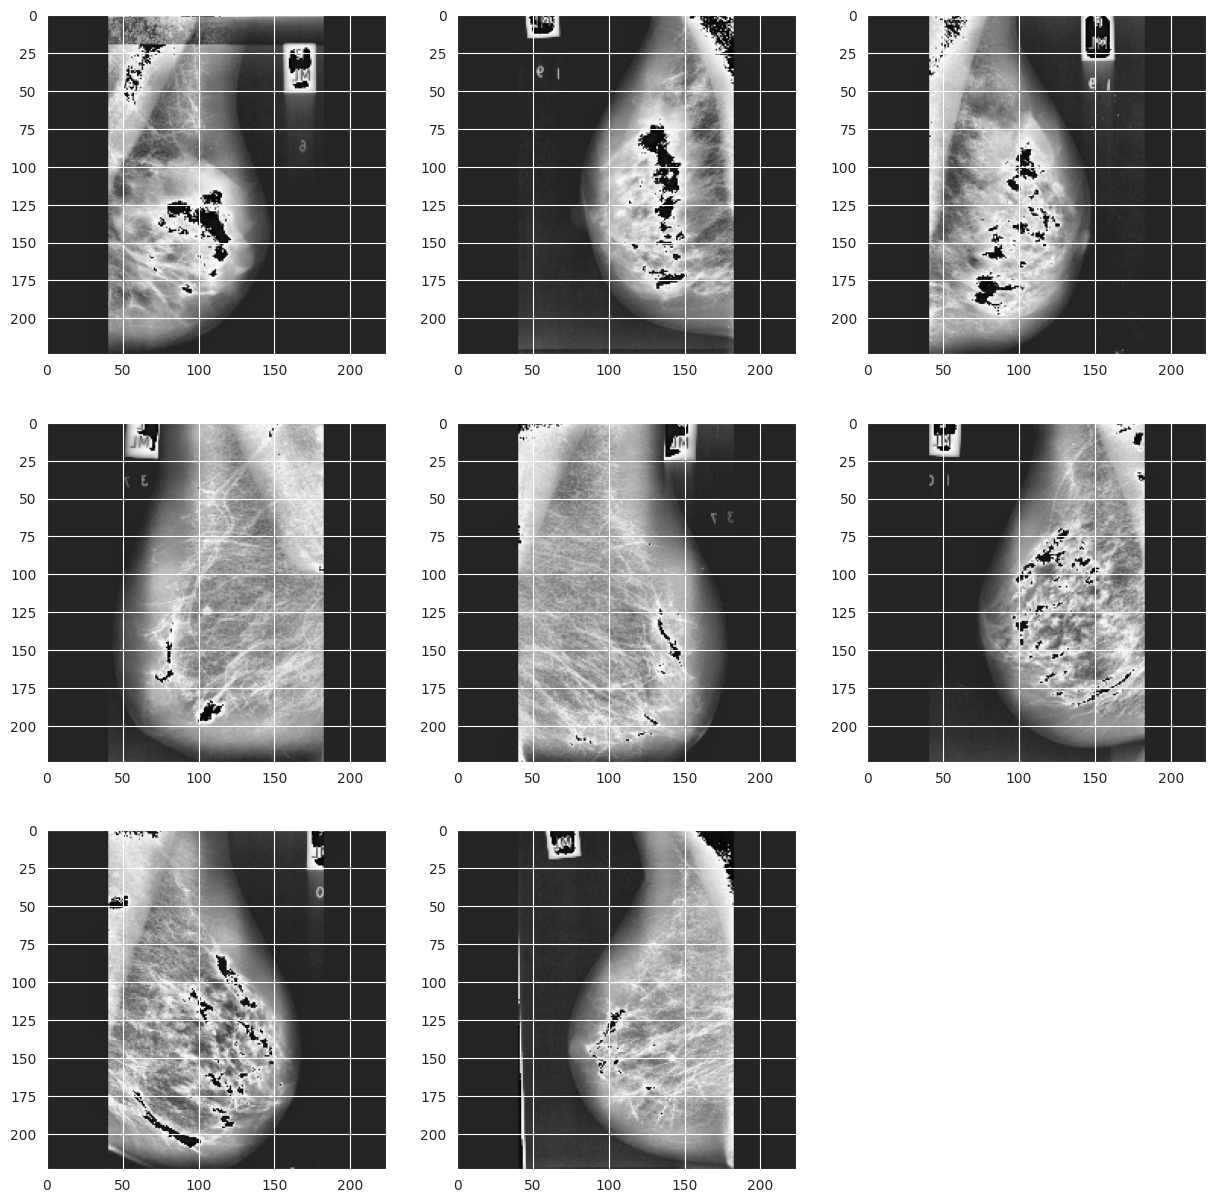

In [6]:
from PIL import Image
import glob
x= []
for filename in sorted(glob.glob("/content/drive/MyDrive/Datasets/MIAS/all-mias-clahe/*.pgm")):
    img=cv2.imread(filename)
    img =cv2.resize(img,(224, 224))
    x.append(img)
fig=plt.figure(figsize=(15,15))
columns = 3
rows = 3
for i in range(1, 9):
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i])
plt.show()

In [7]:
no_angles = 360
url = '/content/drive/MyDrive/Datasets/MIAS/all-mias-clahe/'

def save_dictionary(path,data):
        print('saving catalog...')
        #open('u.item', encoding="utf-8")
        import json
        with open(path,'w') as outfile:
            json.dump(str(data), fp=outfile)
        # save to file:
        print(' catalog saved')

In [8]:
def read_image():
        print("Reading images")
        import cv2
        info = {}
        for i in range(322):
            if i<9:
                image_name='mdb00'+str(i+1)
            elif i<99:
                image_name='mdb0'+str(i+1)
            else:
                image_name = 'mdb' + str(i+1)
            image_address= url+image_name+'.pgm'
            img = cv2.imread(image_address,1)
            img = cv2.resize(img, (224,224))
            rows, cols,channel = img.shape
            info[image_name]={}
            for angle in range(0,no_angles,8):
                M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
                img_rotated = cv2.warpAffine(img, M, (cols, rows))
                info[image_name][angle]=img_rotated
        return (info)

In [9]:
def read_lable():
    print("Reading labels")
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')
        if len(words)>3:
            if (words[3] == 'B'):
                info[words[0]] = {}
                for angle in range(0,no_angles,8):
                    info[words[0]][angle] = 0
            if (words[3] == 'M'):
                info[words[0]] = {}
                for  angle in range(0,no_angles,8):
                    info[words[0]][angle] = 1
    return (info)

In [10]:
import numpy as np
lable_info=read_lable()
image_info=read_image()
ids=lable_info.keys()

X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])
X=np.array(X)
Y=np.array(Y)
Y=to_categorical(Y,2)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)
print(len(x_train),len(x_val),len(x_test))

Reading labels
Reading images
3622 1087 466


In [11]:
len(x_val)

1087

In [12]:
from keras.applications.inception_v3 import InceptionV3

In [13]:
base_Neural_Net= InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [14]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=20,batch_size=30)

Epoch 1/20
121/121 [==============================] - 26s 75ms/step - loss: 0.9121 - accuracy: 0.5442 - auc: 0.5502
Epoch 2/20
121/121 [==============================] - 8s 64ms/step - loss: 0.6703 - accuracy: 0.6350 - auc: 0.6849
Epoch 3/20
121/121 [==============================] - 8s 64ms/step - loss: 0.5648 - accuracy: 0.7148 - auc: 0.7830
Epoch 4/20
121/121 [==============================] - 8s 67ms/step - loss: 0.4539 - accuracy: 0.7885 - auc: 0.8707
Epoch 5/20
121/121 [==============================] - 8s 67ms/step - loss: 0.3990 - accuracy: 0.8222 - auc: 0.9020
Epoch 6/20
121/121 [==============================] - 8s 66ms/step - loss: 0.3448 - accuracy: 0.8526 - auc: 0.9281
Epoch 7/20
121/121 [==============================] - 8s 66ms/step - loss: 0.2787 - accuracy: 0.8854 - auc: 0.9547
Epoch 8/20
121/121 [==============================] - 8s 65ms/step - loss: 0.2392 - accuracy: 0.9067 - auc: 0.9668
Epoch 9/20
121/121 [==============================] - 8s 65ms/step - loss: 0.18

In [15]:
model.evaluate(x_val,y_val,batch_size=30)

37/37 [==============================] - 5s 95ms/step - loss: 0.4140 - accuracy: 0.8436 - auc: 0.9250


[0.4140486419200897, 0.8436062335968018, 0.9250116348266602]

In [16]:
torch.save(model, "/content/drive/MyDrive/Colab Notebooks/final_notebooks/saved_models(clahe)/inception.hdf5")

In [17]:
load_model = torch.load("/content/drive/MyDrive/Colab Notebooks/final_notebooks/saved_models(clahe)/inception.hdf5")

In [22]:
#y_pred11=model.predict_classes(x_test)
predict_y=load_model.predict(x_test)
y_pred11=np.argmax(predict_y,axis=1)

y_test11=[np.argmax(x) for x in y_test]

#y_pred_prb11=model.predict_proba(x_test)
def predict_prob(number):
  return [number[0],1-number[0]]
y_pred_prb11 = np.array(list(map(predict_prob, model.predict(x_test))))

15/15 [==============================] - 1s 61ms/step


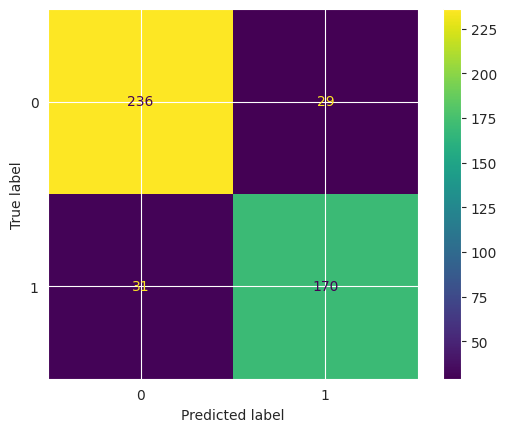

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test11, y_pred11)
plt.show()

In [21]:
print("Accuracy on test images: "+str((218+152)/466))
print(classification_report(y_test11, y_pred11, target_names = ['Benign (Class 0)','Malignant (Class 1)']))

Accuracy on test images: 0.7939914163090128
                     precision    recall  f1-score   support

   Benign (Class 0)       0.88      0.89      0.89       265
Malignant (Class 1)       0.85      0.85      0.85       201

           accuracy                           0.87       466
          macro avg       0.87      0.87      0.87       466
       weighted avg       0.87      0.87      0.87       466

